In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam
import time
from keras.models import load_model
#from target_data_electronic70_7 import target_X, target_y ,test_X, test_y
#from m4databasis21_7 import base_domain,zt_in,zt_out,M4Meta,inputsize,train_12,train_12_y
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from tensorflow.keras.losses import Loss
import tensorflow as tf
#from m4databasis35_7_70_7 import train_35,train_35_y,train_70,train_70_y
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Add, Concatenate,Flatten,Reshape
#import pandas as pd
#####################################################################################
X_train = pd.read_csv("../task_transfer_solor_7/data/M4_lookback.csv").iloc[:,(1):].values
y_train = pd.read_csv("../task_transfer_solor_7/data/M4_lookback_test.csv").iloc[:,1:].values
X_train.shape[1], y_train.shape[1]

target_X= pd.read_csv("mid_X.csv").iloc[:,(1+24*0):].values
target_y =pd.read_csv("mid_y.csv").iloc[:,1:].values
#test_X= pd.read_csv("../data/solor_val_input_7.csv").iloc[:,(1+24*0):].values
#test_y =pd.read_csv("../data/solor_val_output_7.csv").iloc[:,1:].values

from sklearn.model_selection import train_test_split


target_X,test_X,target_y,test_y=train_test_split(target_X[-round(target_X.shape[0] / 10):],target_y[-round(target_y.shape[0] / 10):],random_state=1, shuffle=False)


backcast_length = X_train.shape[1]
forecast_length = y_train.shape[1]

X_train.shape,test_X.shape,y_train.shape,test_y.shape

target_X.shape,test_X.shape
#################################################################################
# loss SMAPE
class SMAPE(Loss):
    def call(self, y_true, y_pred):
        y_pred = tf.reshape(y_pred, tf.shape(y_true))  # 예측 값의 차원을 맞춤
       # y_pred=tf.clip_by_value(y_pred, 1e-10, tf.reduce_max(y_pred))
       # y_true = tf.clip_by_value(y_true, 1e-10, tf.reduce_max(y_true))
        
        numerator = 100 * tf.abs(y_true- y_pred )
        denominator =  (tf.abs(y_true ) + tf.abs(y_pred))/2
        smape =  numerator /  denominator #tf.clip_by_value(denominator, 1e-10, tf.reduce_max(denominator))
        return tf.reduce_mean(smape)

#################################################################################
# loss MASE
class MASE(Loss):
    def __init__(self, training_data, period, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.scale = self.calculate_scale(training_data, period)
    def seasonal_diff(data, period):
        return data[period:] - data[:-period]

    def calculate_scale(self, training_data, period):
        # 주기 차분 계산
        diff = seasonal_diff(training_data, period)
        scale = np.mean(np.abs(diff))
        return scale
    
    def call(self, y_true, y_pred):
        y_pred = tf.reshape(y_pred, tf.shape(y_true))  # 차원 맞추기
        error = tf.abs(y_true - y_pred)
        return tf.reduce_mean(error / self.scale)

def seasonal_diff(data, period):
    return data[period:] - data[:-period]

#################################################################################
#################################################################################
# 하이퍼파라미터 인자 설정
def hyperparameter():
    # 1 backcast
    # 2 forecast
    # 3 inputdim
    # 4 outputdim
    # 5 unit
    # 6 bacth size
    return X_train.shape[1], y_train.shape[1],1,1,128

#################################################################################
# nbeats + I모델 생성 함수
def bulid_model(backcast_,forecast_,input_dim,output_dim,unit):
    model= NBeatsKeras(backcast_length=backcast_, 
                       forecast_length=forecast_,
                       input_dim=input_dim,
                       output_dim=output_dim,
                       stack_types=(NBeatsKeras.TREND_BLOCK,
                                    NBeatsKeras.TREND_BLOCK,
                                    NBeatsKeras.TREND_BLOCK,
                                    NBeatsKeras.SEASONALITY_BLOCK,
                                    NBeatsKeras.SEASONALITY_BLOCK,
                                    NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=1, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=unit)
    return model 
#################################################################################
# nbeats + G모델 생성 함수    
def bulid_model_G(backcast_,forecast_,input_dim,output_dim,unit):
    model= NBeatsKeras(backcast_length=backcast_, 
                       forecast_length=forecast_,
                       input_dim=input_dim,
                       output_dim=output_dim,
                       stack_types=(NBeatsKeras.GENERIC_BLOCK,NBeatsKeras.GENERIC_BLOCK)
                   ,nb_blocks_per_stack=5, thetas_dim=(4,4),
                   share_weights_in_stack=False, hidden_layer_units=unit)
    return model 
#################################################################################
# nbeats + I모델 부트스트랩 샘플링 배깅

def train_bagging_models(num_models, loss_fn , epochs_, patience_,batch_size_,lr):
    models = {}
    backcast,forecast,in_dim,out_dim,unit = hyperparameter()
    historys = []
    for n in range(num_models):
        K.clear_session()
        model = bulid_model(backcast,forecast,in_dim,out_dim,unit)
       # model.set_weights(pretrained_weights)  # 전이 학습 가중치 적용
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer , loss=loss_fn)
        
        # 부트스트랩 샘플링
        select = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_bootstrap = X_train[select]
        y_bootstrap = y_train[select]
        early_stop = EarlyStopping(monitor='val_loss', patience = patience_, verbose = 0, restore_best_weights=True)
        history = model.fit(X_bootstrap, y_bootstrap, batch_size = batch_size_,
                  epochs=epochs_, verbose=0, 
                  callbacks=[early_stop],
                 validation_split = 0.2)
        models[f'model_{n+1}'] = model
        historys.append(history)
        #models.append(model)
        print(f"'########################################################Model{n}")
    return models,historys
#################################################################################
# nbeats + I모델 부트스트랩 샘플링 배깅

def train_bagging_models_G(num_models, loss_fn, epochs_, patience_, batch_size_, lr):
    models = {}
    backcast, forecast, in_dim, out_dim, unit = hyperparameter()
    historys = []
    
    for n in range(num_models):
        K.clear_session()  # 세션 초기화
        model = bulid_model_G(backcast, forecast, in_dim, out_dim, unit)
        # model.set_weights(pretrained_weights)  # 전이 학습 가중치 적용 (필요 시)
        
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss=loss_fn)
        
        # 부트스트랩 샘플링
        select = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_bootstrap = X_train[select]
        y_bootstrap = y_train[select]
        
        # EarlyStopping 콜백
        early_stop = EarlyStopping(monitor='val_loss', patience=patience_, restore_best_weights=True)
        
        # 모델 학습
        history = model.fit(X_bootstrap, y_bootstrap, batch_size=batch_size_,
                            epochs=epochs_, verbose=0, 
                            callbacks=[early_stop],
                            validation_split=0.2)
        
        # 학습된 모델 저장 (각 모델을 'model_n.h5' 형식으로 저장)
        model_filename = f'model_{n+1}.h5'
       # model.save(model_filename)
        print(f"Model {n+1} saved as {model_filename}")
        
        # 모델과 학습 기록 저장
        models[f'model_{n+1}'] = model
        historys.append(history)
        
        print(f"######################################################## Model {n+1} complete")

    return models, historys
#################################################################################
##########################################################################################
# 트랜스퍼 레이어
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = layers.Dropout(rate=dropout)

        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[np.newaxis, ...]

        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, x):
        x = x + self.pe[:, :tf.shape(x)[1], :]
        return self.dropout(x)
##########################################################################################
# 트랜스퍼 레이어
def create_model(fn,d_model, nlayers, nhead, dropout, iw, ow,lr,pretrained_output_reshaped,inputs):
    
    
    x = layers.Dense(d_model // 2, activation='relu')(pretrained_output_reshaped)
    x = layers.Dense(d_model, activation='relu')(x)
    
    pos_encoding = PositionalEncoding(d_model, dropout)
    x = pos_encoding(x)
    
    for _ in range(nlayers):
        attn_output = layers.MultiHeadAttention(num_heads=nhead, key_dim=d_model, dropout=dropout)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        ffn_output = layers.Dense(d_model, activation='relu')(x)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)
    
    x = layers.Dense(d_model // 2, activation='relu')(x)
    x = layers.Dense(1)(x)
    x = tf.squeeze(x, axis=-1)
    
    outputs = layers.Dense((iw + ow) // 2, activation='relu')(x)
    outputs = layers.Dense(ow)(outputs)
    
    optimizer = Adam(learning_rate=lr)
    target_model = Model(inputs=inputs, outputs=outputs)
    target_model.compile(optimizer=optimizer, loss=fn)
    
    return target_model
########################################################################################################################
def transfer_(model_num,models,trainable,
              lossf,epochs_,batch_size_,pt,lr_):
    model_mapes_G = {}
    history_mapes_G = []
    model_pred = []
    for i in range(1, model_num+1):
        K.clear_session()
        model_name = f'model_{i}'
        m,_ = models#[model_name]
        model1= m[model_name]
        # 모든 레이어를 학습 불가능하게 설정
        for layer in model1.layers[:-1]:  # 새로운 레이어 추가된 부분은 학습 가능하도록 설정
            layer.trainable = trainable
        pretrained_layers = model1.layers[:-1]
        
        pretrained_model = Model(inputs=model1.input, outputs=pretrained_layers[-1].output)
        
        inputs = Input(shape=(X_train.shape[1], 1))
        pretrained_output = pretrained_model(inputs)
        pretrained_output_reshaped = layers.Reshape((y_train.shape[1], -1))(pretrained_output)
            
        model_instance = create_model(lossf ,d_model=64, nlayers=1,nhead=1, dropout=0.1, iw=X_train.shape[1], ow=y_train.shape[1],lr=lr_
                                      ,pretrained_output_reshaped=pretrained_output_reshaped,inputs=inputs)
        early_stop = EarlyStopping(monitor='val_loss', patience=pt, verbose=0, restore_best_weights=True)
    
        history = model_instance.fit(target_X, target_y, batch_size = batch_size_,
                      epochs=epochs_, verbose=0, 
                      callbacks=[early_stop],
                     validation_split = 0.2)
        pred = model_instance.predict(test_X)
        pred = pred.reshape(-1,y_train.shape[1])
        model_pred.append(pred)
        history_mapes_G.append(history)
        model_mapes_G[f'model_{i}'] =model_instance
        #del model_instance
        print(f"'########################################################fitted{i}")
    return model_pred ,history_mapes_G
#################################################################################
# 예측

def bagging_predict(models, X):
    predictions = np.array([model.predict(X) for model in models.values()])
    return np.median(predictions, axis=0)

def bagging_predict2(models, X):
    predictions = np.array([model.predict(X) for model in models.values()])
    return predictions

2024-09-18 18:35:53.648540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 18:35:53.749421: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-18 18:35:53.749443: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-18 18:35:54.262319: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [2]:
mape_models = train_bagging_models_G(5,'mape',500,30,512,0.001)
smape_models = train_bagging_models_G(5,SMAPE(),500,30,512,0.001)
mase_models = train_bagging_models_G(5,MASE(y_train,y_train.shape[1]),500,30,512,0.001)
mse_models = train_bagging_models_G(5,'mse',500,30,512,0.001)
mae_models = train_bagging_models_G(5,'mae',500,30,512,0.001)

2024-09-18 18:36:16.962810: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-18 18:36:16.962869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ymlee2-desktop): /proc/driver/nvidia/version does not exist
2024-09-18 18:36:16.963520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model 1 saved as model_1.h5
######################################################## Model 1 complete
Model 2 saved as model_2.h5
######################################################## Model 2 complete
Model 3 saved as model_3.h5
######################################################## Model 3 complete
Model 4 saved as model_4.h5
######################################################## Model 4 complete
Model 5 saved as model_5.h5
######################################################## Model 5 complete
Model 1 saved as model_1.h5
######################################################## Model 1 complete
Model 2 saved as model_2.h5
######################################################## Model 2 complete
Model 3 saved as model_3.h5
######################################################## Model 3 complete
Model 4 saved as model_4.h5
######################################################## Model 4 complete
Model 5 saved as model_5.h5
######################################################

In [3]:
mape_pred = transfer_(5,mape_models,True, 'mape',500,8,1000,0.0005)
mase_pred = transfer_(5,mase_models,True, MASE(target_y,y_train.shape[1]),500,8,1000,0.0005)
smape_pred = transfer_(5,smape_models,True, SMAPE(),500,8,500,0.0005)
mse_pred = transfer_(5,mape_models,True, 'mse',500,8,1000,0.0005)
mae_pred = transfer_(5,mape_models,True, 'mae',500,8,1000,0.0005)

1/1 [==============================] - 1s 541ms/step
'########################################################fitted1
1/1 [==============================] - 1s 528ms/step
'########################################################fitted2
1/1 [==============================] - 1s 533ms/step
'########################################################fitted3
1/1 [==============================] - 1s 538ms/step
'########################################################fitted4
1/1 [==============================] - 1s 516ms/step
'########################################################fitted5
1/1 [==============================] - 1s 525ms/step
'########################################################fitted1
1/1 [==============================] - 1s 530ms/step
'########################################################fitted2
1/1 [==============================] - 1s 539ms/step
'########################################################fitted3
1/1 [==============================] - 0s 339ms/step
'##

In [4]:
concat_G = np.concatenate([np.array(mase_pred[0]),np.array(mape_pred[0]),np.array(smape_pred[0]),
                          np.array(mae_pred[0]),np.array(mse_pred[0])])

fin_pred_G = np.median(concat_G,axis=0)

mean_squared_error(test_y.flatten(),fin_pred_G.flatten()),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(4.523574886046668, 1.694303435861169)

In [5]:
pd.DataFrame({'mape':[mean_squared_error(test_y.flatten(),np.array(mape_pred[0])[i].flatten()) for i in range(5)],
              'smape':[mean_squared_error(test_y.flatten(),np.array(smape_pred[0])[i].flatten()) for i in range(5)],
              'mase':[mean_squared_error(test_y.flatten(),np.array(mase_pred[0])[i].flatten()) for i in range(5)],
              'mae':[mean_squared_error(test_y.flatten(),np.array(mae_pred[0])[i].flatten()) for i in range(5)],
              'mse':[mean_squared_error(test_y.flatten(),np.array(mse_pred[0])[i].flatten()) for i in range(5)]
             })

,mape,smape,mase,mae,mse
0,6.488085,6.845577,5.744565,11.183493,10.039903
1,6.197955,5.524896,7.947774,7.343203,8.934747
2,7.006302,6.567699,6.473059,7.047876,7.558404
3,5.702144,5.731473,6.743985,8.001870,7.097880
4,5.724010,6.000937,5.886257,10.094016,8.223487


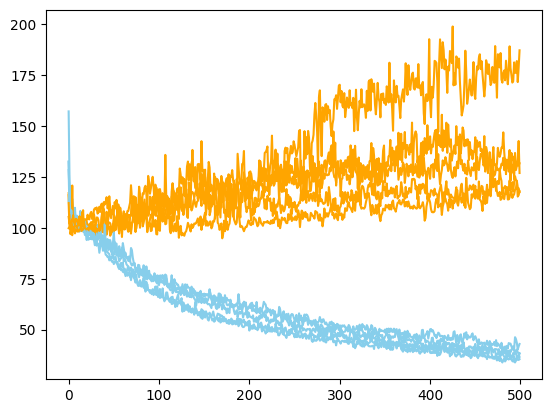

In [6]:

for i in range(5):
    plt.plot(mape_pred[1][i].history['loss'],color = 'skyblue')
    plt.plot(mape_pred[1][i].history['val_loss'],color = 'orange')

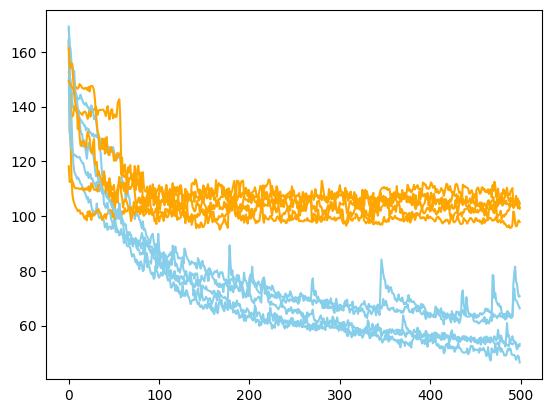

In [7]:

for i in range(5):
    plt.plot(smape_pred[1][i].history['loss'],color = 'skyblue')
    plt.plot(smape_pred[1][i].history['val_loss'],color = 'orange')

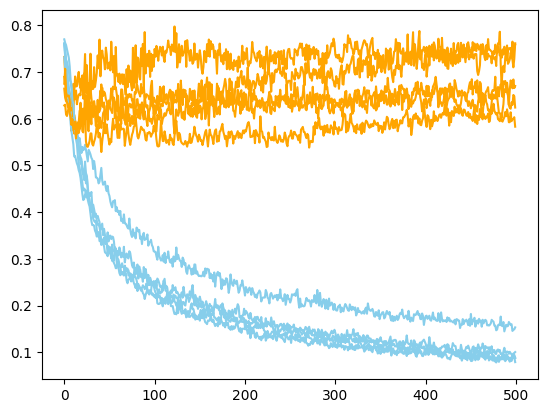

In [8]:

for i in range(5):
    plt.plot(mase_pred[1][i].history['loss'],color = 'skyblue')
    plt.plot(mase_pred[1][i].history['val_loss'],color = 'orange')

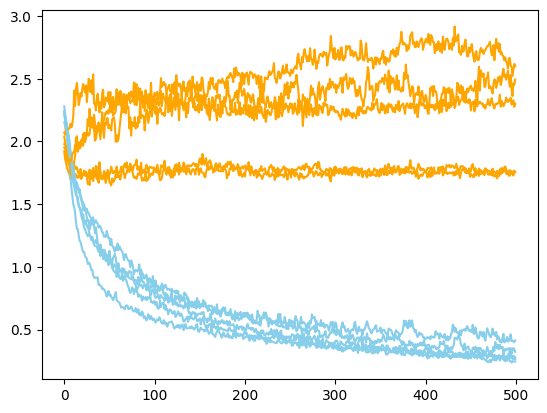

In [9]:

for i in range(5):
    plt.plot(mae_pred[1][i].history['loss'],color = 'skyblue')
    plt.plot(mae_pred[1][i].history['val_loss'],color = 'orange')

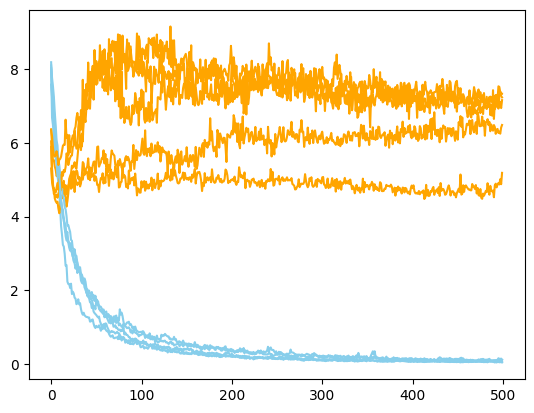

In [10]:

for i in range(5):
    plt.plot(mse_pred[1][i].history['loss'],color = 'skyblue')
    plt.plot(mse_pred[1][i].history['val_loss'],color = 'orange')